# BEE 4750 Homework 3: Dissolved Oxygen and Monte Carlo

**Name**:

**ID**:

> **Due Date**
>
> Thursday, 10/03/23, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to implement a model for dissolved oxygen in a
    river with multiple waste releases and use this to develop a
    strategy to ensure regulatory compliance.
-   Problem 2 asks you to use Monte Carlo simulation to assess how well
    your strategy from Problem 1 performs under uncertainty.
-   Problem 3 (5750 only) asks you to identify where a third discharge
    should be placed to maintain regulatory compliance.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [56]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\arisc\OneDrive\Desktop\BEE 4750\hw3-ari-jiaming-grace`


In [57]:
using Random
using Plots
using LaTeXStrings
using Distributions
using CSV
using DataFrames

## Problems (Total: 50/60 Points)

### Problem 1 (30 points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart. The oxygen reaeration rate is 0.55
day<sup>-1</sup>, and the decay rates of CBOD and NBOD are are 0.35 and
0.25 day<sup>-1</sup>, respectively. The river’s saturated dissolved
oxygen concentration is 10m g/L.

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

| Parameter | River Inflow | Waste Stream 1 | Waste Stream 2 |
|:--:|---:|---:|---:|
| Inflow | 100,000 m<sup>3</sup>/d | 10,000 m<sup>3</sup>/d | 15,000 m<sup>3</sup>/d |
| DO Concentration | 7.5 mg/L | 5 mg/L | 5 mg/L |
| CBOD | 5 mg/L | 50 mg/L | 45 mg/L |
| NBOD | 5 mg/L | 35 mg/L | 35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

**In this problem**:

-   Plot the dissolved oxygen concentration from the first waste stream
    to 50m downriver. What is the minimum value in mg/L?
-   What is the minimum level of treatment (% removal of organic waste)
    for waste stream 1 that will ensure that the dissolved oxygen
    concentration never drops below 4 mg/L, assuming that waste stream 2
    remains untreated? How about if only waste stream 2 is treated?
-   Suppose you are responsible for designing a waste treatment plan for
    discharges into the river, with a regulatory mandate to keep the
    dissolved oxygen concentration above 4 mg/L. Discuss whether you’d
    opt to treat waste stream 2 alone or both waste streams equally.
    What other information might you need to make a conclusion, if any?

In [58]:
#function to calculate DO curve
function DO_River(u, dx, x, Cs, ka, kc, kn, Qin, Q1, Q2, Cin, C1, C2, Bin, B1, B2, Nin, N1, N2)
    Qi = Qin + Q1
    B0i = ((Qin*Bin) + (Q1*B1))/Qi
    N0i = ((Qin*Nin) + (Q1*N1))/Qi
    C0i = ((Qin*Cin) + (Q1*C1))/Qi
    Bi = B0i*exp(-kc*dx/u)
    Ni = N0i*exp(-kn*dx/u)
    Ci = C0i*exp(-ka*dx/u)
    B0j = ((Qi*Bi)+(Q2*B2))/(Qi+Q2)
    N0j = ((Qi*Ni)+(Q2*N2))/(Qi+Q2)
    C0j = ((Qi*Ci)+(Q2*C2))/(Qi+Q2)
    Cx = []
    min = Cs #mg/L - DO can never surpass this so it's a guarantee that we'll get a number less as the minimum
    xmin = 0 #km
    max = 0 #mg/L because DO will have to be above this
    xmax = 0 #km

    for b in 1:length(x)
        if x[b] <= dx
            push!(Cx, Cs*(1-exp(-ka*x[b]/u)) + C0i*exp(-ka*x[b]/u) - B0i*(kc/(ka-kc))*(exp(-kc*x[b]/u)-exp(-ka*x[b]/u)) - N0i*(kn/(ka-kn))*(exp(-kn*x[b]/u)-exp(-ka*x[b]/u)))
        elseif x[b] > dx
            push!(Cx, Cs*(1-exp((-ka*x[b])/u)) + C0j*exp((-ka*x[b])/u) - B0j*(kc/(ka-kc))*(exp((-kc*x[b])/u)-exp((-ka*x[b])/u)) - N0j*(kn/(ka-kn))*(exp((-kn*x[b])/u)-exp((-ka*x[b])/u)))
        end
        if Cx[b] < min
            min = Cx[b]
            xmin = x[b]
        end
        if Cx[b] > max
            max = Cx[b]
            xmax = x[b]
        end
    end
    return Cx, min, xmin, max, xmax
end

DO_River (generic function with 1 method)

Maximum DO Concentration is 8.502814728392396 mg/L, which occurs 50.0km downstream from the first wastewater input.
Minimum DO Concentration is 3.680660824630159 mg/L, which occurs 15.003000600120023km downstream from the first wastewater input.


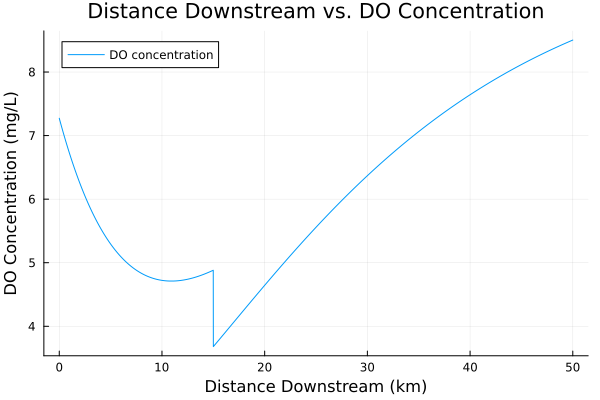

In [59]:
#define necessary variables
u = 6 #km/day
dx = 15 #km - referring to distance between 2 inputs
Cs = 10 #mg/L
ka = 0.55 # d^-1
kc = 0.35 #d^-1
kn = 0.25 #d^-1
Qin = 10^5 #m^3/day
Q1 = 10^4 #m^3/day
Q2 = 1.5*(10^4) #m^3/day
Cin = 7.5 #mg/L
C1 = 5 #mg/L
C2 = 5 #mg/L
Bin = 5 #mg/L
B1 = 50 #mg/L
B2 = 45 #mg/L
Nin = 5 #mg/L
N1 = 35 #mg/L
N2 = 35 #mg/L
x = LinRange(0, 50, 5000)

Cx, min, xmin, max, xmax = DO_River(u, dx, x, Cs, ka, kc, kn, Qin, Q1, Q2, Cin, C1, C2, Bin, B1, B2, Nin, N1, N2)

println("Maximum DO Concentration is ", max, " mg/L, which occurs ", xmax, "km downstream from the first wastewater input.")
println("Minimum DO Concentration is ", min, " mg/L, which occurs ", xmin, "km downstream from the first wastewater input.")


plot(x, Cx, label = "DO concentration")
title!("Distance Downstream vs. DO Concentration")
xlabel!("Distance Downstream (km)")
ylabel!("DO Concentration (mg/L)")


What is the minimum level of treatment (% removal of organic waste)
    for waste stream 1 that will ensure that the dissolved oxygen
    concentration never drops below 4 mg/L, assuming that waste stream 2
    remains untreated? How about if only waste stream 2 is treated?

38.5% is the minimum efficiency of removal at wastewater treatment plant 1 to maintain DO at or above 4 mg/L


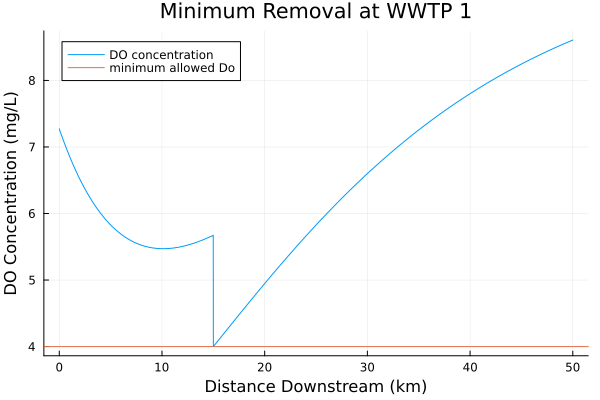

In [60]:
# WWTP 1
eff = LinRange(0, 1, 1001)
min = 0
i = 0
while min < 4
    i+=1
    Ba = (1-eff[i])*B1
    Na = (1-eff[i])*N1
    Cx, min, xmin, max, xmax = DO_River(u, dx, x, Cs, ka, kc, kn, Qin, Q1, Q2, Cin, C1, C2, Bin, Ba, B2, Nin, Na, N2)
end
if min == 0
    println("Even at 100% removal efficiency and wastewater treatment plant 1, the DO will drop below 4 mg/L")
else
    println(eff[i]*100, "% is the minimum efficiency of removal at wastewater treatment plant 1 to maintain DO at or above 4 mg/L")
    
end
plot(x, Cx, label = "DO concentration")
title!("Minimum Removal at WWTP 1")
xlabel!("Distance Downstream (km)")
ylabel!("DO Concentration (mg/L)")
hline!([4], label="minimum allowed Do")

12.6% is the minimum efficiency of removal at wastewater treatment plant 2 to maintain DO at or above 4 mg/L


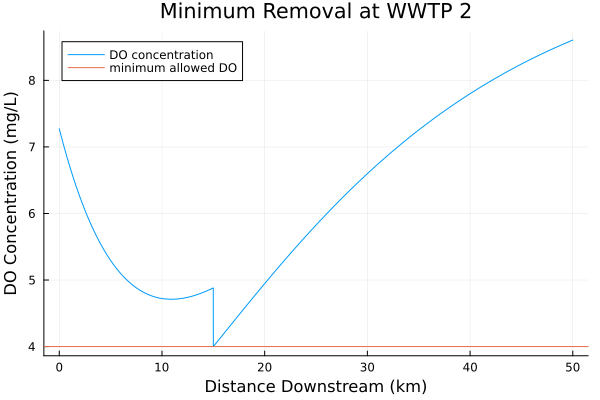

In [61]:
# WWTP 2
eff = LinRange(0, 1, 1001)
min = 0
i = 0
while min < 4
    i+=1
    Bb = (1-eff[i])*B2
    Nb = (1-eff[i])*N2
    Cx, min, xmin, max, xmax = DO_River(u, dx, x, Cs, ka, kc, kn, Qin, Q1, Q2, Cin, C1, C2, Bin, B1, Bb, Nin, N1, Nb)
end
if min == 0
    println("Even at 100% removal efficiency and wastewater treatment plant 2, the DO will drop below 4 mg/L")
else
    println(eff[i]*100, "% is the minimum efficiency of removal at wastewater treatment plant 2 to maintain DO at or above 4 mg/L")
    
end
plot(x, Cx, label = "DO concentration")
title!("Minimum Removal at WWTP 2")
xlabel!("Distance Downstream (km)")
ylabel!("DO Concentration (mg/L)")
hline!([4], label="minimum allowed DO")

Suppose you are responsible for designing a waste treatment plan for
    discharges into the river, with a regulatory mandate to keep the
    dissolved oxygen concentration above 4 mg/L. Discuss whether you’d
    opt to treat waste stream 2 alone or both waste streams equally.
    What other information might you need to make a conclusion, if any?

9.5% is the minimum efficiency of removal at at both plants to maintain DO at or above 4 mg/L


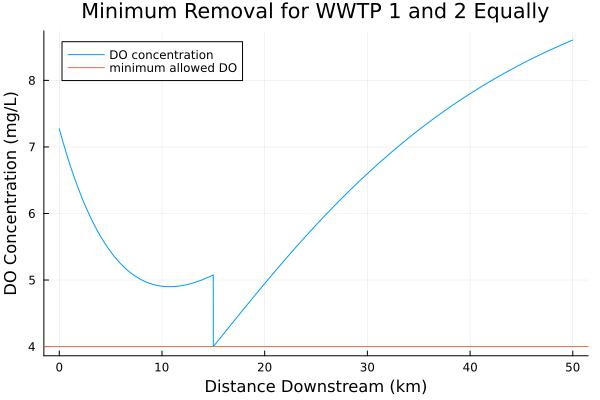

In [62]:
# Treating Both Equally
eff = LinRange(0, 1, 1001)
min = 0
i = 0
while min < 4
    i+=1
    Ba = (1-eff[i])*B1
    Na = (1-eff[i])*N1
    Bb = (1-eff[i])*B2
    Nb = (1-eff[i])*N2
    Cx, min, xmin, max, xmax = DO_River(u, dx, x, Cs, ka, kc, kn, Qin, Q1, Q2, Cin, C1, C2, Bin, Ba, Bb, Nin, Na, Nb)
end
if min == 0
    println("Even at 100% removal efficiency at both plants, the DO will drop below 4 mg/L")
else
    println(eff[i]*100, "% is the minimum efficiency of removal at at both plants to maintain DO at or above 4 mg/L")
    
end
plot(x, Cx, label = "DO concentration")
title!("Minimum Removal for WWTP 1 and 2 Equally")
xlabel!("Distance Downstream (km)")
ylabel!("DO Concentration (mg/L)")
hline!([4], label="minimum allowed DO")

### Problem 1 Write Up

To plot the DO concentration in the river, we wrote a function to implement the DO model for two box models in series. The first box was from $X = 0 \ km$ to $X = 15 \ km$, were $X = 0 \ km$ is measured from the mixing point of the river and the first water treatment plant effluent. I used the formula for the DO concentration that we derived in lecture using the given values. Assuming that the rates of photosynthesis, respiration, and benthal uptake are zero, we can use the other given parameters in this formula. First, we need to calculate the initial BOD, which we will call ${B}_{0, i}$, and NOD after mixing, which we will call ${N}_{0, i}$ using the formulas: ${B}_{0, i} = \frac{{Q}_{in}*{B}_{in} + Q_1*B_1}{{Q}_{in} + Q_1}$ and ${N}_{0, i} = \frac{{Q}_{in}*{N}_{in} + Q_1*N_1}{{Q}_{in} + Q_1}$. Then, we can just substitute into our equation for DO Concentration: ${C}_{DO}(X) = C_S(1-{e}^{-\frac{k_aX}{u}} + C_0{e}^{-\frac{k_aX}{u}} - {B}_{0, i}(\frac{k_c}{k_a-k_c})({e}^{-\frac{k_cX}{u}}-{e}^{-\frac{k_aX}{u}}) - {N}_{0, i}(\frac{k_cn}{k_a-k_n})({e}^{-\frac{k_nX}{u}}-{e}^{-\frac{k_aX}{u}})$. 

This is the equation for the first $15 \ km$, so now we need to address what happens after the second wastewater effluent joins the river in other words, the second box. To do this, we need to again solve for the mixed BOD, which I will call $B_i$, and NOD, which I will call $N_i$, at $X = 15 \ km$. To do this, we can use the equations $B_i = {B}_{0, i}{e}^{-\frac{k_cX}{u}}$ and $N_i = {N}_{0, i}{e}^{-\frac{k_nX}{u}}$ at $X = 15 \ km$. Then, we can use the same formula we used to calculate ${B}_{0, i}$ and ${N}_{0, i}$ to calculate mixed BOD, which I called ${B}_{0, j}$, and NOD, which I called ${N}_{0, j}$, at $X = 15 \ km$: ${B}_{0, j} = \frac{({Q}_{in} + {Q}_{1})*{B}_{i} + Q_2*B_2}{{Q}_{in} + Q_1 + Q_2}$ and ${N}_{0, j} = \frac{({Q}_{in} + {Q}_{1})*{N}_{i} + Q_2*N_2}{{Q}_{in} + Q_1 + Q_2}$. Then, we can just substitute into our formula for DO concentration to get: ${C}_{DO}(X) = C_S(1-{e}^{-\frac{k_aX}{u}} + C_0{e}^{-\frac{k_aX}{u}} - {B}_{0, j}(\frac{k_c}{k_a-k_c})({e}^{-\frac{k_cX}{u}}-{e}^{-\frac{k_aX}{u}}) - {N}_{0, j}(\frac{k_cn}{k_a-k_n})({e}^{-\frac{k_nX}{u}}-{e}^{-\frac{k_aX}{u}})$. 

The function iterates through an array of inputted $X$ values to calculate the DO Concentration, so to calculate the minimum and maximum concentrations, I initially stored the highest possible value, $C_S$, in the minimum variable and the lowest possible value, $0$, in the maximum variable. Then, I replaced the minimum variable any time I got a concentration value lower than the current minimum and replaced the maximum any time I got a higher value than the current.

To calculate the minimum treatment level to keep the minimum DO above $4 \ \frac{mg}{L}$, I iterated through efficiencies, starting at zero and increasing by $0.1%$ for each iteration, calling the function I wrote to calculate DO concentration until the minimum value was greater than or equal to 4. To apply the efficiency, we change the BOD and NOD inputs at plant 1 to $(1-efficiency)*B_1$ and $(1-efficiency)*N_1$. I did the same thing for plant 2 and both plants. 

Based on only the information given, I would suggest treating both inflows with 9.5% removal efficiency because this means less percent removal is required at each individual plant. If we only treat the water from WWTP 2, we need to treat it to 12.6% removal efficiency. Additionally, I think it is only fair that the first plant contribute to the treatment effort as well because they input more total oxygen demand as well.

### Problem 2 (20 points)

The simplest climate model involves capturing changes to the Earth’s
energy budget (it is commonly called the *energy balance model*, or
EBM). These changes are also called *radiative forcings* (RF), and can
result from several causes, including greenhouse gas emissions, volcanic
eruptions, and changes to the solar cycle. The EBM treats the Earth as a
0-dimensional sphere covered with water, which absorbs heat in response
to radiative forcings. Chanwith global temperature changes resulting
from imbalances in the average (over the entire surface area) heat flux.

The EBM equations are:

$$
\begin{align*}
\overbrace{\frac{dH}{dt}}^{\text{change in heat}} &= \overbrace{F}^{\substack{\text{radiative} \\ \text{forcing}}} - \overbrace{\lambda T}^{\substack{\text{change in} \\ \text{temperature}}} \\
\underbrace{C}_{\substack{\text{ocean heat} \\ \text{capacity}}} \frac{dT}{dt} &= F - \lambda T \\
c\underbrace{d}_{\substack{\text{ocean} \\ \text{mixing depth}}} \frac{dT}{dt} &= F - \lambda T,
\end{align*}
$$

where $c = 4.184\times 10^6 \mathrm{J/K/m}^2$ is the specific heat of
water per area, $d$ is the depth of the ocean mixed layer (we’ll assume
$d = 86 \mathrm{m}$), and $\lambda$ is the **climate feedback factor**
and controls how much the Earth warms in response to increased radiative
forcing (assume
$\lambda = 2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2$)). The total
radiative forcing $F = F_\text{non-aerosol} + \alpha F_\text{aerosol}$,
where $\alpha$ is an uncertain scaling factor reflecting aerosol-cloud
feedbacks (we’ll assume $\alpha = 0.8$).

The code below loads historical and projected radiative forcings (under
the SSP5-8.5 future emissions scenario, which is the most extreme of the
scenarios used to project climate change impacts) from
`data/ERF_ssp585_1750-2500.csv` into a `DataFrame` object and calculates
the non-aerosol and aerosol components of those forcings.

> **Tip**
>
> Look closely at and experiment with the code below: `DataFrames` are a
> common Julia datatype for tabular data, and you may work more with
> them later in the semester or beyond! They are broadly similar to
> `DataFrames` from `pandas` in Python.

In [63]:
# Dataset from https://zenodo.org/record/3973015
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
forcings_all = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# Separate out the individual components
# Get total aerosol forcings
forcing_aerosol_rad = forcings_all[!,"aerosol-radiation_interactions"]
forcing_aerosol_cloud = forcings_all[!,"aerosol-cloud_interactions"]
forcing_aerosol = forcing_aerosol_rad + forcing_aerosol_cloud
# Calculate non-aerosol forcings from the total.
forcing_total = forcings_all[!,"total"]
forcing_non_aerosol = forcing_total - forcing_aerosol

751-element Vector{Float64}:
  0.25918289716993287
  0.24176756635599128
  0.21325975144045076
  0.17850291224529793
  0.1457411149414377
  0.09840432796857469
 -0.13383410588305977
  0.01724897551757567
  0.14777213389926366
  0.22712653379357609
  ⋮
 12.638871538651715
 12.636828023749903
 12.634811388909599
 12.632786007467395
 12.630739504290775
 12.628694395288093
 12.626673788131408
 12.624680005793559
 12.623637075242984

We can plot the aerosol and non-aerosol forcings below.

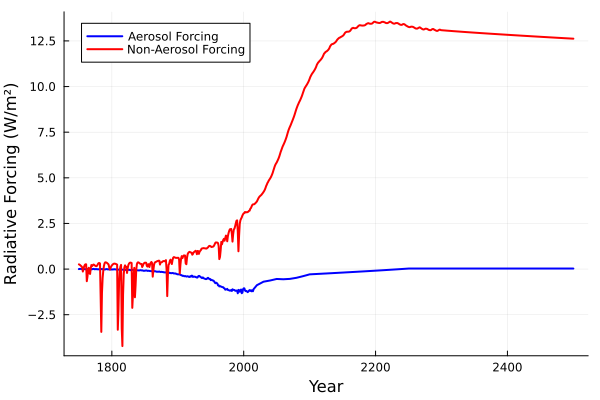

In [64]:
t = Int64.(forcings_all[!,"year"]) # Ensure that years are interpreted as integers
p_forcing = plot(; xlabel="Year", ylabel="Radiative Forcing (W/m²)")
plot!(p_forcing, t, forcing_aerosol, label="Aerosol Forcing", color=:blue, linewidth=2)
plot!(p_forcing, t, forcing_non_aerosol, label="Non-Aerosol Forcing", color=:red, linewidth=2)

**In this problem**:

-   Discretize the EBM to produce a simulation model of global mean
    temperatures $T$ over time as a result of total radiative forcings
    $F$.


In [65]:
#function uses a forward Euler method to discretize the radiative forcing temperature equation
function global_mean_temperature(c, d, lambda, F, T0, dt)
    T = [T0]
    for i in 1:length(F)-1
        dT = (F[i]-(lambda*T[i]))/(c*d)
        T1 = T[i] + dT*dt
        push!(T, T1)
    end
    return T
end

global_mean_temperature (generic function with 1 method)


-   Simulate global mean temperature anomalies (in $^\circ C$ relative
    to 1750) from your model using the historical and SSP5-8.5 radiative
    forcing data. Use an annual time step for the simulation (in
    seconds: $\Delta t = 31,558,152 \mathrm{s}$). You can assume
    $T(0) = 0^\circ C$. Plot the resulting temperature simulation.


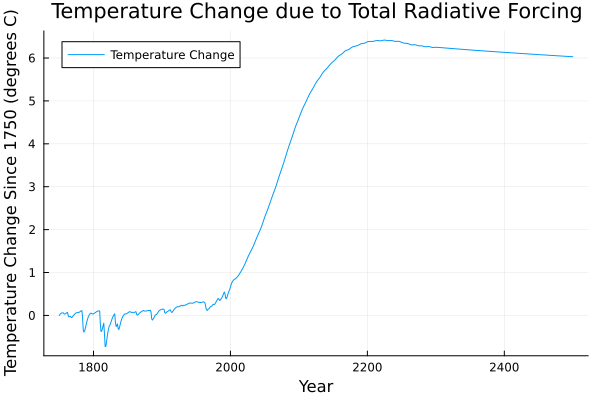

In [66]:
c = 4.184*10^6 #J/K/m^2
d = 86.0 #m 
lambda = 2.1 #degrees C/(W/m^2)
F = forcing_total #total forcing from SSP5-8.5 dataset
alpha = 0.8
T0 = 0.0 #degrees C 
dt = 31558152.0 #seconds
Temp = global_mean_temperature(c, d, lambda, F, T0, dt)
Years = LinRange(1750, 2500, 751)
plot(Years, Temp, label = "Temperature Change")
xlabel!("Year")
ylabel!("Temperature Change Since 1750 (degrees C)")
title!("Temperature Change due to Total Radiative Forcing")


-   The climate feedback factor $\lambda$ is one of the key
    uncertainties in projecting future temperatures, even assuming a
    particular scenario of future radiative forcing. Suppose we use the
    following distribution for $\lambda$,
    $$\lambda \sim \text{LogNormal}(\log(2.1), \log(2)/4).$$

    Use Monte Carlo simulation to estimate the expected temperature in
    2100 assuming SSP5-RCP 8.5 radiative forcings (with 95% confidence
    intervals). How does this estimate compare to the value you got from
    your simulation using the expected value of
    $\lambda=2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2)$? How did
    you decide your sample set was sufficient?

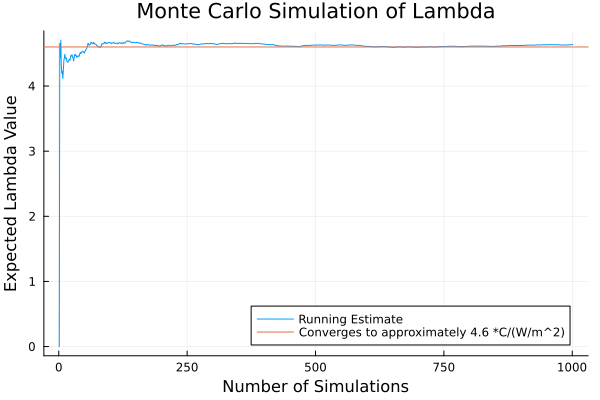

In [67]:
Random.seed!(1)
lambda_dist = LogNormal(log(2.1), log(2)/4)
lambda_samples = rand(lambda_dist, 1000)
F_2100 = F[1:351]
T = [0.0]
T_tot = 0.0

for i in 1:length(lambda_samples)
    Temps = global_mean_temperature(c, d, lambda_samples[i], F, T0, dt)
    T_tot = T_tot + Temps[351]
    T_ave = T_tot/i
    push!(T, T_ave)
end


plot(T, label = "Running Estimate")
hline!([4.6], label = "Converges to approximately 4.6 *C/(W/m^2)")
xlabel!("Number of Simulations")
ylabel!("Expected Lambda Value")
title!("Monte Carlo Simulation of Lambda")

### Problem 2 Write Up

For the first part of this problem, I wrote a function that uses the forward Euler method to calculate the global mean temperatures. To do this, you have to calculate the "slope" for the linear approximation by solving for $\frac{dT}{dt} = \frac{F-T\lambda}{cd}$ at  time $t_i$. Then, we solve the linear equation to get ${T}_{i+1} = T_i + \frac{dT}{dt}dt$. 

To calculate the flobal temperature anomlies relative to 1750, we just have to input the given initial values into the function and then plot it.

## I just realized I solved for $\lambda$ for this instead of T so my Monte Carlo is wrong but I'll fix it

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

A factory is planning a third wastewater discharge into the river
downstream of the second plant. This discharge would consist of 5
m<sup>3</sup>/day of wastewater with a dissolved oxygen content of 4.5
mg/L and CBOD and NBOD levels of 50 and 45 mg/L, respectively.

**In this problem**:

-   Assume that the treatment plan you identified in Problem 1 is still
    in place for the existing discharges. If the third discharge will
    not be treated, under the original inflow conditions (7.5 mg/L DO),
    how far downstream from the second discharge does this third
    discharge need to be placed to keep the river concentration from
    dropping below 4 mg/L?

## References

List any external references consulted, including classmates.